In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl as xl
import os

import warnings
warnings.filterwarnings('ignore')

## AppliancesEnergy

In [24]:
from typing import List

def find_file(names: List[str], n):
    for i in names:
        if i.startswith(str(n)):
            return i
    return None
        
def check_result_existance(folder, experiment):
    full_path = os.path.join(folder, experiment)
    if not [f for f in os.listdir(full_path) if f.endswith('xlsx')]:
        return False
    return True

folder = '../results/InceptionNet/AppliancesEnergy/'

true_ops = ['low_rank', 'pruning', 'quant_dynamic', 'quant_static', 'quant_qat']
experiments = [f for f in os.listdir(folder) if f != '.DS_Store']

final_df = pd.DataFrame()
final_comput = {}

for exp in experiments:
    step_dict = {}

    if not check_result_existance(folder, exp):
        continue

    words = exp.split('_')
    words = [w.replace('-', '_') for w in words]

    sequences = []
    operation = []
    for word in words:
        operation.append(word)
        current_op = '_'.join(operation)
        
        if current_op in true_ops:
            sequences.append(current_op)
            operation = []
        elif word in true_ops:
            sequences.append(word)
            operation = []
            
    for ind, oper in enumerate(sequences):
        step_dict[f'op_{ind}'] = oper


    seq = exp
    files = os.listdir(folder + seq)

    xlsx = [f for f in files if f.endswith('xlsx')]

    metric_dict = {}
    comp_dict = {}

    for step in range(4):
        step_result_file = find_file(xlsx, step)

        if step_result_file is None:
            continue

        xls = pd.ExcelFile(folder + seq + '/' + step_result_file)
        quality = pd.read_excel(xls, 'quality_comparison')
        quality.columns = quality.iloc[0]
        quality = quality.drop(quality.index[0])
        

        computational = pd.read_excel(xls, 'computational_comparison')
        if step == 0:

            init_rmse = quality[quality['mode'] == 'rmse']['original'].values[0]
            latency_init, size_init, thr_init = computational.iloc[2, 1], computational.iloc[3, 1], computational.iloc[4, 1]
            comp_dict['init'] = {
                'latency': latency_init,
                'size': size_init,
                'throughput': thr_init
            }
            metric_dict['init_rmse'] = init_rmse
            

        step_rmse = quality[quality['mode'] == 'rmse']['fedcore'].values[0]
        latency_step, size_step, thr_step = computational.iloc[2, 2], computational.iloc[3, 2], computational.iloc[4, 2]
        
        metric_dict[f'step_{step}'] = step_rmse
        comp_dict[f'step_{step}'] = {
                'latency': latency_step,
                'size': size_step,
                'throughput': thr_step
            }
    
    final_comput[f'{exp}'] = comp_dict


    metric_df = pd.DataFrame(metric_dict, index=[0])
    steps_df = pd.DataFrame(step_dict, index=[0])
    final_exp_df = pd.concat([steps_df, metric_df], axis=1)

    final_df = pd.concat([final_df, final_exp_df], axis=0).reset_index(drop=True)

final_df = final_df[['op_0', 'op_1', 'op_2', 'op_3', 'init_rmse', 'step_0', 'step_1', 'step_2', 'step_3']]

# FORWARDD FILL FOR SKIPPED STEPS AND DROP PIPELINES WHERE NO INIT VALUE
numerical_cols = final_df.select_dtypes(include=['int64', 'float64']).columns
final_df[numerical_cols] = final_df[numerical_cols].fillna(method='ffill', axis=1).dropna(axis=0).reset_index(drop=True)
								
data = final_df.copy()
data.columns = data.columns.str.strip()
for col in ['init_rmse', 'step_0', 'step_1', 'step_2', 'step_3']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# rows with missing step_3 for final comparison
data_step3 = data.copy()
data_step3 = data.dropna(subset=['step_3'])
data_step3['combination'] = data_step3[['op_0', 'op_1', 'op_2', 'op_3']].agg(' → '.join, axis=1)

top_combinations = data_step3[['combination', 'init_rmse', 'step_3']].sort_values(by='step_3', ascending=True).reset_index(drop=True)

print("\nTop 5 Combinations by step_3 F1 Score:")
print(top_combinations.head(5).to_string(index=False))



Top 5 Combinations by step_3 F1 Score:
                                      combination  init_rmse  step_3
low_rank → quant_static → pruning → quant_dynamic      3.441   3.811
   quant_dynamic → low_rank → quant_qat → pruning      3.441   3.817
low_rank → quant_dynamic → pruning → quant_static      3.441   3.841
    low_rank → quant_qat → pruning → quant_static      3.441   3.845
   pruning → quant_dynamic → low_rank → quant_qat      3.441   4.577


In [25]:
final_df

,op_0,op_1,op_2,op_3,init_rmse,step_0,step_1,step_2,step_3
0,low_rank,quant_static,pruning,quant_qat,3.441,3.446,3.446,5.278,5.278
1,quant_dynamic,low_rank,pruning,quant_qat,3.441,3.480,3.480,5.803,5.803
2,low_rank,quant_dynamic,pruning,quant_static,3.441,7.650,7.650,3.841,3.841
3,pruning,quant_qat,low_rank,quant_dynamic,3.441,3.491,3.491,5.813,5.813
4,low_rank,quant_dynamic,pruning,quant_qat,3.441,12.686,12.686,10.642,10.642
5,pruning,quant_dynamic,low_rank,quant_qat,3.441,3.468,3.468,4.577,4.577
6,quant_dynamic,low_rank,pruning,quant_static,3.441,3.471,3.471,5.057,5.057
7,quant_dynamic,low_rank,quant_static,pruning,3.441,3.468,3.468,5.138,5.138
8,low_rank,quant_qat,pruning,quant_dynamic,3.441,11.446,11.446,9.378,9.378
9,quant_dynamic,low_rank,quant_qat,pruning,3.441,6.263,6.263,3.817,3.817


In [26]:
best_comb = top_combinations.combination[0].replace('_', '-').replace(' → ', '_')
ops = best_comb.split('_')

best_comb

'low-rank_quant-static_pruning_quant-dynamic'

In [27]:
top_combinations

,combination,init_rmse,step_3
0,low_rank → quant_static → pruning → quant_dynamic,3.441,3.811
1,quant_dynamic → low_rank → quant_qat → pruning,3.441,3.817
2,low_rank → quant_dynamic → pruning → quant_static,3.441,3.841
3,low_rank → quant_qat → pruning → quant_static,3.441,3.845
4,pruning → quant_dynamic → low_rank → quant_qat,3.441,4.577
5,quant_dynamic → low_rank → pruning → quant_static,3.441,5.057
6,quant_dynamic → low_rank → quant_static → pruning,3.441,5.138
7,low_rank → quant_static → pruning → quant_qat,3.441,5.278
8,quant_dynamic → low_rank → pruning → quant_qat,3.441,5.803
9,pruning → quant_qat → low_rank → quant_dynamic,3.441,5.813


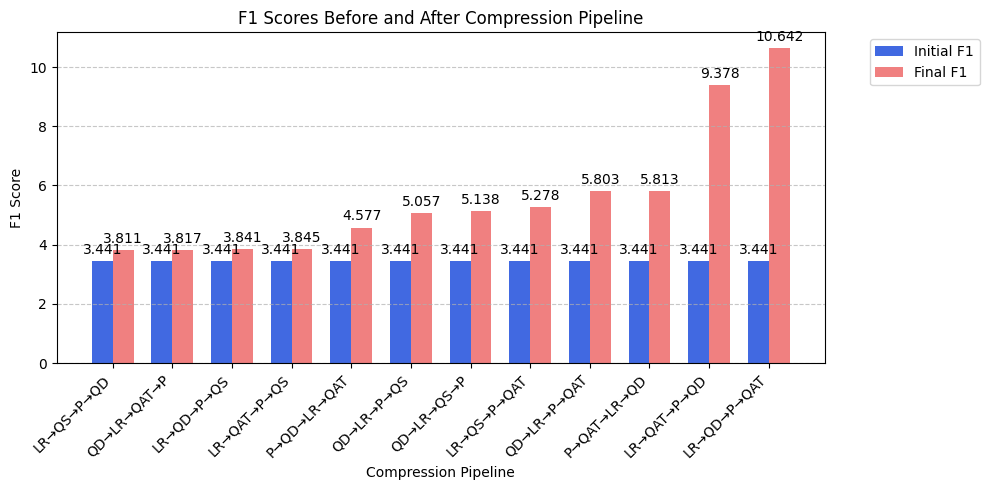

In [29]:
combinations = top_combinations['combination'].values

init_f1 = top_combinations['init_rmse'].values
step_3 = top_combinations['step_3'].values   # Step 3 F1 scores

# Create shortened labels for better readability

mapping = {
    'low_rank': 'LR',
    'quant_static': 'QS',
    'pruning': 'P',
    'quant_qat': 'QAT',
    'quant_dynamic': 'QD'
}

short_labels = []
for comb in combinations:
    for key, value in mapping.items():
        comb = comb.replace(key, value)
    comb = comb.replace(' → ', '→')
    short_labels.append(comb)
# print(shorts)

# short_labels = ['LR→QD→PR→QQ', 'LR→QQ→PR→QD', 'LR→QS→PR→QQ', 'LR→QS→PR→QD']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Set width of bars
bar_width = 0.35
x = np.arange(len(combinations))


bars1 = ax.bar(x - bar_width/2, init_f1, bar_width, label='Initial F1', color='royalblue')
bars2 = ax.bar(x + bar_width/2, step_3, bar_width, label='Final F1', color='lightcoral')


ax.set_xlabel('Compression Pipeline')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores Before and After Compression Pipeline')
ax.set_xticks(x)
ax.set_xticklabels(short_labels, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.savefig('imgs/timeseries_metric.png', dpi=500)
plt.show()

<Axes: >

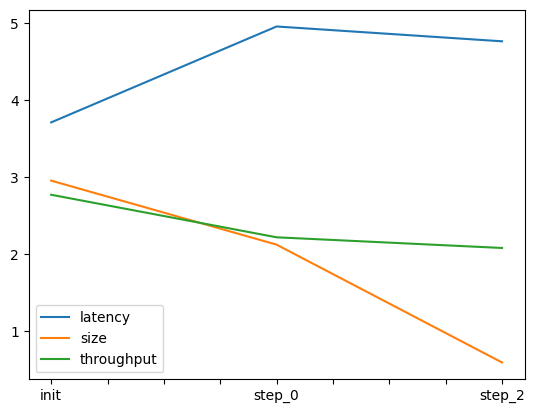

In [30]:
pd.DataFrame(final_comput[best_comb]).T.plot()


Trend Slopes: ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value

low-rank_quant-static_pruning_quant-qat_latency_slope: 0.2325
low-rank_quant-static_pruning_quant-qat_size_slope: -1.5310
low-rank_quant-static_pruning_quant-qat_throughput_slope: -0.1526
quant-dynamic_low-rank_pruning_quant-qat_latency_slope: -0.2394
quant-dynamic_low-rank_pruning_quant-qat_size_slope: -1.5310
quant-dynamic_low-rank_pruning_quant-qat_throughput_slope: 0.0166
low-rank_quant-dynamic_pruning_quant-static_latency_slope: -0.1063
low-rank_quant-dynamic_pruning_quant-static_size_slope: -0.7068
low-rank_quant-dynamic_pruning_quant-static_throughput_slope: -0.0777
pruning_quant-qat_low-rank_quant-dynamic_latency_slope: 0.9563
pruning_quant-qat_low-rank_quant-dynamic_size_slope: -0.1530
pruning_quant-qat_low-rank_quant-dynamic_throughput_slope: -0.8413
low-rank_quant-dynamic

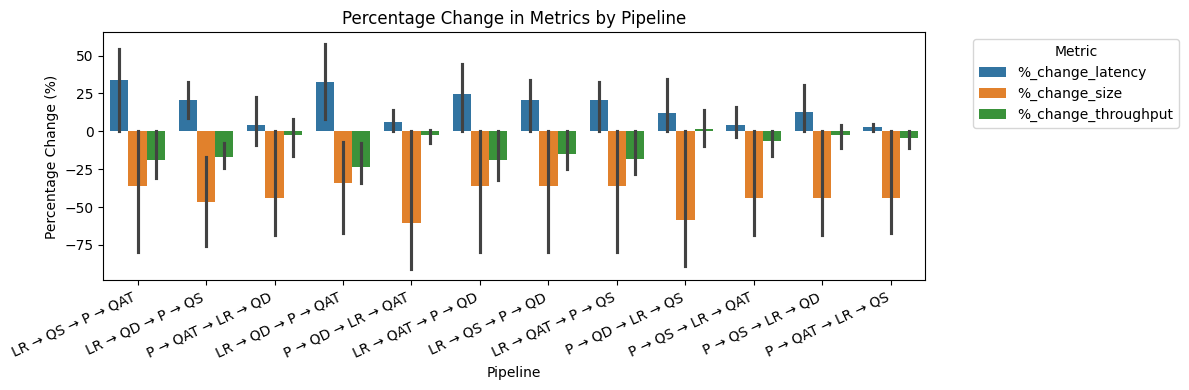

In [31]:
import seaborn as sns

data = final_comput
# low-rank_quant-static_pruning_quant-qat
rows = []
mapping = {
    'low-rank': 'LR',
    'quant-static': 'QS',
    'pruning': 'P',
    'quant-qat': 'QAT',
    'quant-dynamic': 'QD'
}

for pipeline, steps in data.items():
    if 'init' not in steps:
        continue
    for key, value in mapping.items():
        pipeline = pipeline.replace(key, value)
    
    pipeline = pipeline.replace('_', ' → ')

    for step, metrics in steps.items():
        rows.append({'pipeline': pipeline, 'step': step, **metrics})
df = pd.DataFrame(rows)


def calc_percent_change(group, metric):
    init_val = group[group['step'] == 'init'][metric].iloc[0]
    return ((group[metric] - init_val) / init_val * 100).round(2)

for metric in ['latency', 'size', 'throughput']:
    df[f'%_change_{metric}'] = df.groupby('pipeline').apply(lambda x: calc_percent_change(x, metric)).reset_index(level=0, drop=True)


summary_stats = df.groupby(['pipeline', 'step']).agg({
    'latency': ['mean', 'std'],
    'size': ['mean', 'std'],
    'throughput': ['mean', 'std'],
    f'%_change_latency': 'mean',
    f'%_change_size': 'mean',
    f'%_change_throughput': 'mean'
}).round(3)

trends = {}
for pipeline in data.keys():
    steps = [s for s in data[pipeline].keys() if s != 'init']
    step_indices = range(len(steps))
    for metric in ['latency', 'size', 'throughput']:
        values = [data[pipeline][s][metric] for s in steps]
        try:
            coeffs = np.polyfit(step_indices, values, 1)
        except:
            coeffs = [np.nan, np.nan]
        trends[f"{pipeline}_{metric}_slope"] = coeffs[0]
print("\nTrend Slopes:")
for key, value in trends.items():
    print(f"{key}: {value:.4f}")

melted_df = df.melt(id_vars=['pipeline', 'step'], 
                    value_vars=[f'%_change_{m}' for m in ['latency', 'size', 'throughput']],
                    var_name='metric', value_name='percent_change')
plt.figure(figsize=(12, 4))
sns.barplot(data=melted_df, x='pipeline', hue='metric', y='percent_change')
plt.title('Percentage Change in Metrics by Pipeline')
plt.xlabel('Pipeline')
plt.ylabel('Percentage Change (%)')
plt.xticks(rotation=25, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

plt.savefig('imgs/timeseries_gpu.png', dpi=500)
plt.show()